# Equatorial Pacific

This notebook demonstrates the key features of  equatorial Pacific Ocean circulation using ACCESS-OM3 data, with comparisons to ACCESS-OM2 and observational results from Johnson et al. (2002). The figures reproduce Fig 19 from the [GMD ACCESS-OM2 paper](https://gmd.copernicus.org/articles/13/401/2020/).



In [ ]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
# esm_file = "/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"
# esm_file='/g/data/ol01/outputs/access-om3-25km/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
esm_file='/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

# needed for mkmd START 
notebook_name='not_using_mkfigs.sh'
notebooks_dir = os.path.join(f"/g/data/tm70/{os.environ['USER']}/access-om3-paper-1", "notebooks")
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())
from mkfigs_configdoc import mkmd,get_notebook_name
notebook_name=get_notebook_name(notebook_name)
## example usage (note if the first argument to mkmd remains the same, you can insert multiple figures from the same notebook): 
#plt.savefig(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
#mkmd("Template notebook","`"+notebook_name+"`: Example figure of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
#mkmd("Template notebook","`"+notebook_name+"`: Example figure of another type.",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
# needed for mkmd STOP

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json
Plot folder path:  /g/data/tm70/ml0072/access-om3-paper-figs/


In [2]:
IAF = esm_file.find('iaf') > 0
IAF

True

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import intake
import matplotlib.pyplot as plt
from distributed import Client
import cmocean as cm

In [4]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


### Open the intake-esm datastore

In [5]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)

### What ocean variables are available at monthly frequency?

In [6]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [7]:
datastore_filtered = datastore.search(realm="ocean", frequency="1mon", variable="uo")

available_variables(datastore_filtered)

variable_long_name variable_standard_name  \
variable                                                           
average_DT       Length of average period                          
average_T1  Start time for average period                          
average_T2    End time for average period                          
nv                          vertex number                          
time                                 time                          
time_bnds            time axis boundaries                          
uo                   Sea Water X Velocity   sea_water_x_velocity   
xq              q point nominal longitude                          
yh               h point nominal latitude                          
z_i                    Depth at interface                          
z_l                  Depth at cell center                          

                           variable_cell_methods  \
variable                                           
average_DT                                         
average_T1                                         
average_T2                                         
nv                                                 
time                                               
time_bnds                                          
uo          z_l:mean yh:mean xq:point time: mean   
xq                                                 
yh                                                 
z_i                                                
z_l                                                

                            variable_units  
variable                                    
average_DT                            days  
average_T1  days since 1900-01-01 00:00:00  
average_T2  days since 1900-01-01 00:00:00  
nv                                          
time        days since 1900-01-01 00:00:00  
time_bnds   days since 1900-01-01 00:00:00  
uo                                   m s-1  
xq                            degrees_east  
yh                           degrees_north  
z_i                                 meters  
z_l                                 meters

### ACCESS-OM2 dataset

In [8]:
cat = intake.cat.access_nri
om2_experiment = "025deg_jra55_iaf_omip2_cycle6"
om2_datastore = cat[om2_experiment]

In [9]:
temp_om2 = om2_datastore.search(variable="temp", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yt_ocean": -1, "xt_ocean": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

u_om2 = om2_datastore.search(variable="u", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yu_ocean": -1, "xu_ocean": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

### Rename OM2 var name and coords to be consistent with OM3 for plotting purpose

In [10]:
temp_om2 = temp_om2.rename(
    {
        "st_ocean": "z_l",
        "yt_ocean": "yh",
        "xt_ocean": "xh",
        "temp": "thetao"
    }
)

u_om2 = u_om2.rename(
    {
        "st_ocean": "z_l",
        "yu_ocean": "yh",
        "xu_ocean": "xq",
        "u": "uo"
    }
)

### ACCESS-OM3 dataset

In [11]:
temp_om3 = datastore.search(variable="thetao", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

u_om3 = datastore.search(variable="uo", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xq": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


#### NOTE: There's an [ordering issue](https://github.com/ACCESS-NRI/access-om3-configs/pull/725#pullrequestreview-3174863908) in `yh`. This should / will be fixed.

In [12]:
temp_om3 = temp_om3.assign_coords(
    {"yh": temp_om3.yh.sortby("yh")}
)
u_om3 = u_om3.assign_coords(
    {"yh": u_om3.yh.sortby("yh")}
)

### Observation dataset

In [13]:
obs_path = '/g/data/v45/fw4078/obs-data/meanfit_m.cdf'
obs_file = xr.open_dataset(obs_path)

In [14]:
obs_file

<xarray.Dataset> Size: 1MB
Dimensions:     (XLON: 10, XLONedges: 11, YLAT11_101: 91, ZDEP1_50: 50)
Coordinates:
  * XLON        (XLON) float64 80B 143.0 156.0 165.0 180.0 ... 235.0 250.0 265.0
  * XLONedges   (XLONedges) float64 88B 136.5 149.5 160.5 ... 242.5 257.5 272.5
  * YLAT11_101  (YLAT11_101) float64 728B -8.0 -7.8 -7.6 -7.4 ... 9.6 9.8 10.0
  * ZDEP1_50    (ZDEP1_50) float64 400B 5.0 15.0 25.0 35.0 ... 475.0 485.0 495.0
Data variables:
    POTEMPM     (ZDEP1_50, YLAT11_101, XLON) float32 182kB ...
    SALINITYM   (ZDEP1_50, YLAT11_101, XLON) float32 182kB ...
    SIGMAM      (ZDEP1_50, YLAT11_101, XLON) float32 182kB ...
    UM          (ZDEP1_50, YLAT11_101, XLON) float32 182kB ...
    TSPTS       (ZDEP1_50, YLAT11_101, XLON) float32 182kB ...
    UPTS        (ZDEP1_50, YLAT11_101, XLON) float32 182kB ...
Attributes:
    history:  FERRET V5.41    1-Oct-02

In [15]:
temp_obs = obs_file["POTEMPM"].to_dataset()
u_obs = obs_file["UM"].to_dataset()

In [16]:
temp_obs = temp_obs.rename(
    {
        "ZDEP1_50": "z_l",
        "YLAT11_101": "yh",
        "XLON": "xh",
        "POTEMPM": "thetao"
    }
)

u_obs = u_obs.rename(
    {
        "ZDEP1_50": "z_l",
        "YLAT11_101": "yh",
        "XLON": "xq",
        "UM": "uo"
    }
)

In [17]:
u_obs

<xarray.Dataset> Size: 183kB
Dimensions:  (xq: 10, yh: 91, z_l: 50)
Coordinates:
  * xq       (xq) float64 80B 143.0 156.0 165.0 180.0 ... 235.0 250.0 265.0
  * yh       (yh) float64 728B -8.0 -7.8 -7.6 -7.4 -7.2 ... 9.2 9.4 9.6 9.8 10.0
  * z_l      (z_l) float64 400B 5.0 15.0 25.0 35.0 ... 465.0 475.0 485.0 495.0
Data variables:
    uo       (z_l, yh, xq) float32 182kB ...

#### Extract Equatorial Pacific region

In [18]:
def _time_detection(da, tsel):
    """
    observation data does not contain time coord.
    """
    if "time" in da.dims:
        return da.sel(time=tsel).mean("time")
    else:
        return da

def make_sections(
    temp,
    u,
    zsel=slice(0,300),
    xsel=slice(-217, -95),
    ysel=slice(-8,10),
    tsel=slice(pd.Timestamp("1998-01-01"), None),
    x_140w=-140.0,
    yeq=0,
    u_scale=100.0
):
    temp_eq = _time_detection(
        temp.sel(z_l=zsel,xh=xsel).sel(yh=0, method='nearest'), tsel,
    ).compute()
    u_eq = u_scale*_time_detection(
        u.sel(z_l=zsel,xq=xsel).sel(yh=0, method='nearest'), tsel,
    ).compute()
    temp_140w = _time_detection(
        temp.sel(z_l=zsel,yh=ysel).sel(xh=x_140w, method='nearest'), tsel,
    ).compute()
    u_140w = _time_detection(
        u_scale*u.sel(z_l=zsel,yh=ysel).sel(xq=x_140w, method='nearest'), tsel,
    ).compute()

    return temp_eq, u_eq, temp_140w, u_140w

#### ACCESS-OM2 temperature and zonal velocity

In [19]:
temp_eq_om2, u_eq_om2, temp_140w_om2, u_140w_om2 = make_sections(temp_om2, u_om2)
temp_eq_om2 = temp_eq_om2 - 273.15
temp_140w_om2 = temp_140w_om2 - 273.15

#### ACCESS-OM3 temperature and zonal velocity

In [20]:
temp_eq_om3, u_eq_om3, temp_140w_om3, u_140w_om3 = make_sections(temp_om3, u_om3)

#### Observation temperature and zonal velocity

In [21]:
xsel1 = temp_obs.xh.values[0]
xsel2 = temp_obs.xh.values[-1]

temp_eq_obs, u_eq_obs, temp_140w_obs, u_140w_obs = make_sections(temp_obs, u_obs,
                                                                 xsel=slice(xsel1, xsel2),
                                                                 ysel=slice(-8, 10),
                                                                 x_140w=220
                                                                )
                                                                 

### Plot

In [22]:
def plot_pair(ax,
              temp,
              u,
              xdim_temp, xdim_u,
              clevels_temp, clevels_u,
              title,
              show_ylabel=False,
              show_xlabel=False
             ):
    T = temp["thetao"]
    U = u["uo"]

    cf = T.plot.contourf(
        ax=ax,
        x=xdim_temp, y="z_l",
        levels=clevels_temp,
        cmap=cm.cm.thermal,
        extend="both",
        add_colorbar=False,
        zorder=1,
    )
    ct = T.plot.contour(
        ax=ax,
        x=xdim_temp, y="z_l",
        levels=clevels_temp,
        colors="k",
        linewidths=0.5,
        zorder=2,
    )
    cs = U.plot.contour(
        ax=ax,
        x=xdim_u, y="z_l",
        levels=clevels_u,
        colors="w",
        linewidths=1.0,
        zorder=3,
    )

    labels = ax.clabel(cs, fmt="%d", fontsize=9, inline=True)
    for t in labels:
        t.set_color("black")
        t.set_bbox(dict(facecolor="white", edgecolor="none", pad=0.6, alpha=0.75))

    ax.invert_yaxis()
    ax.set_title(title)

    if show_ylabel:
        ax.set_ylabel("Depth (m)")
    else:
        ax.set_ylabel("")

    if show_xlabel:
        ax.set_xlabel(xdim_temp)
    else:
        ax.set_xlabel("")

    ax.grid(False)
    return cf, ct, cs

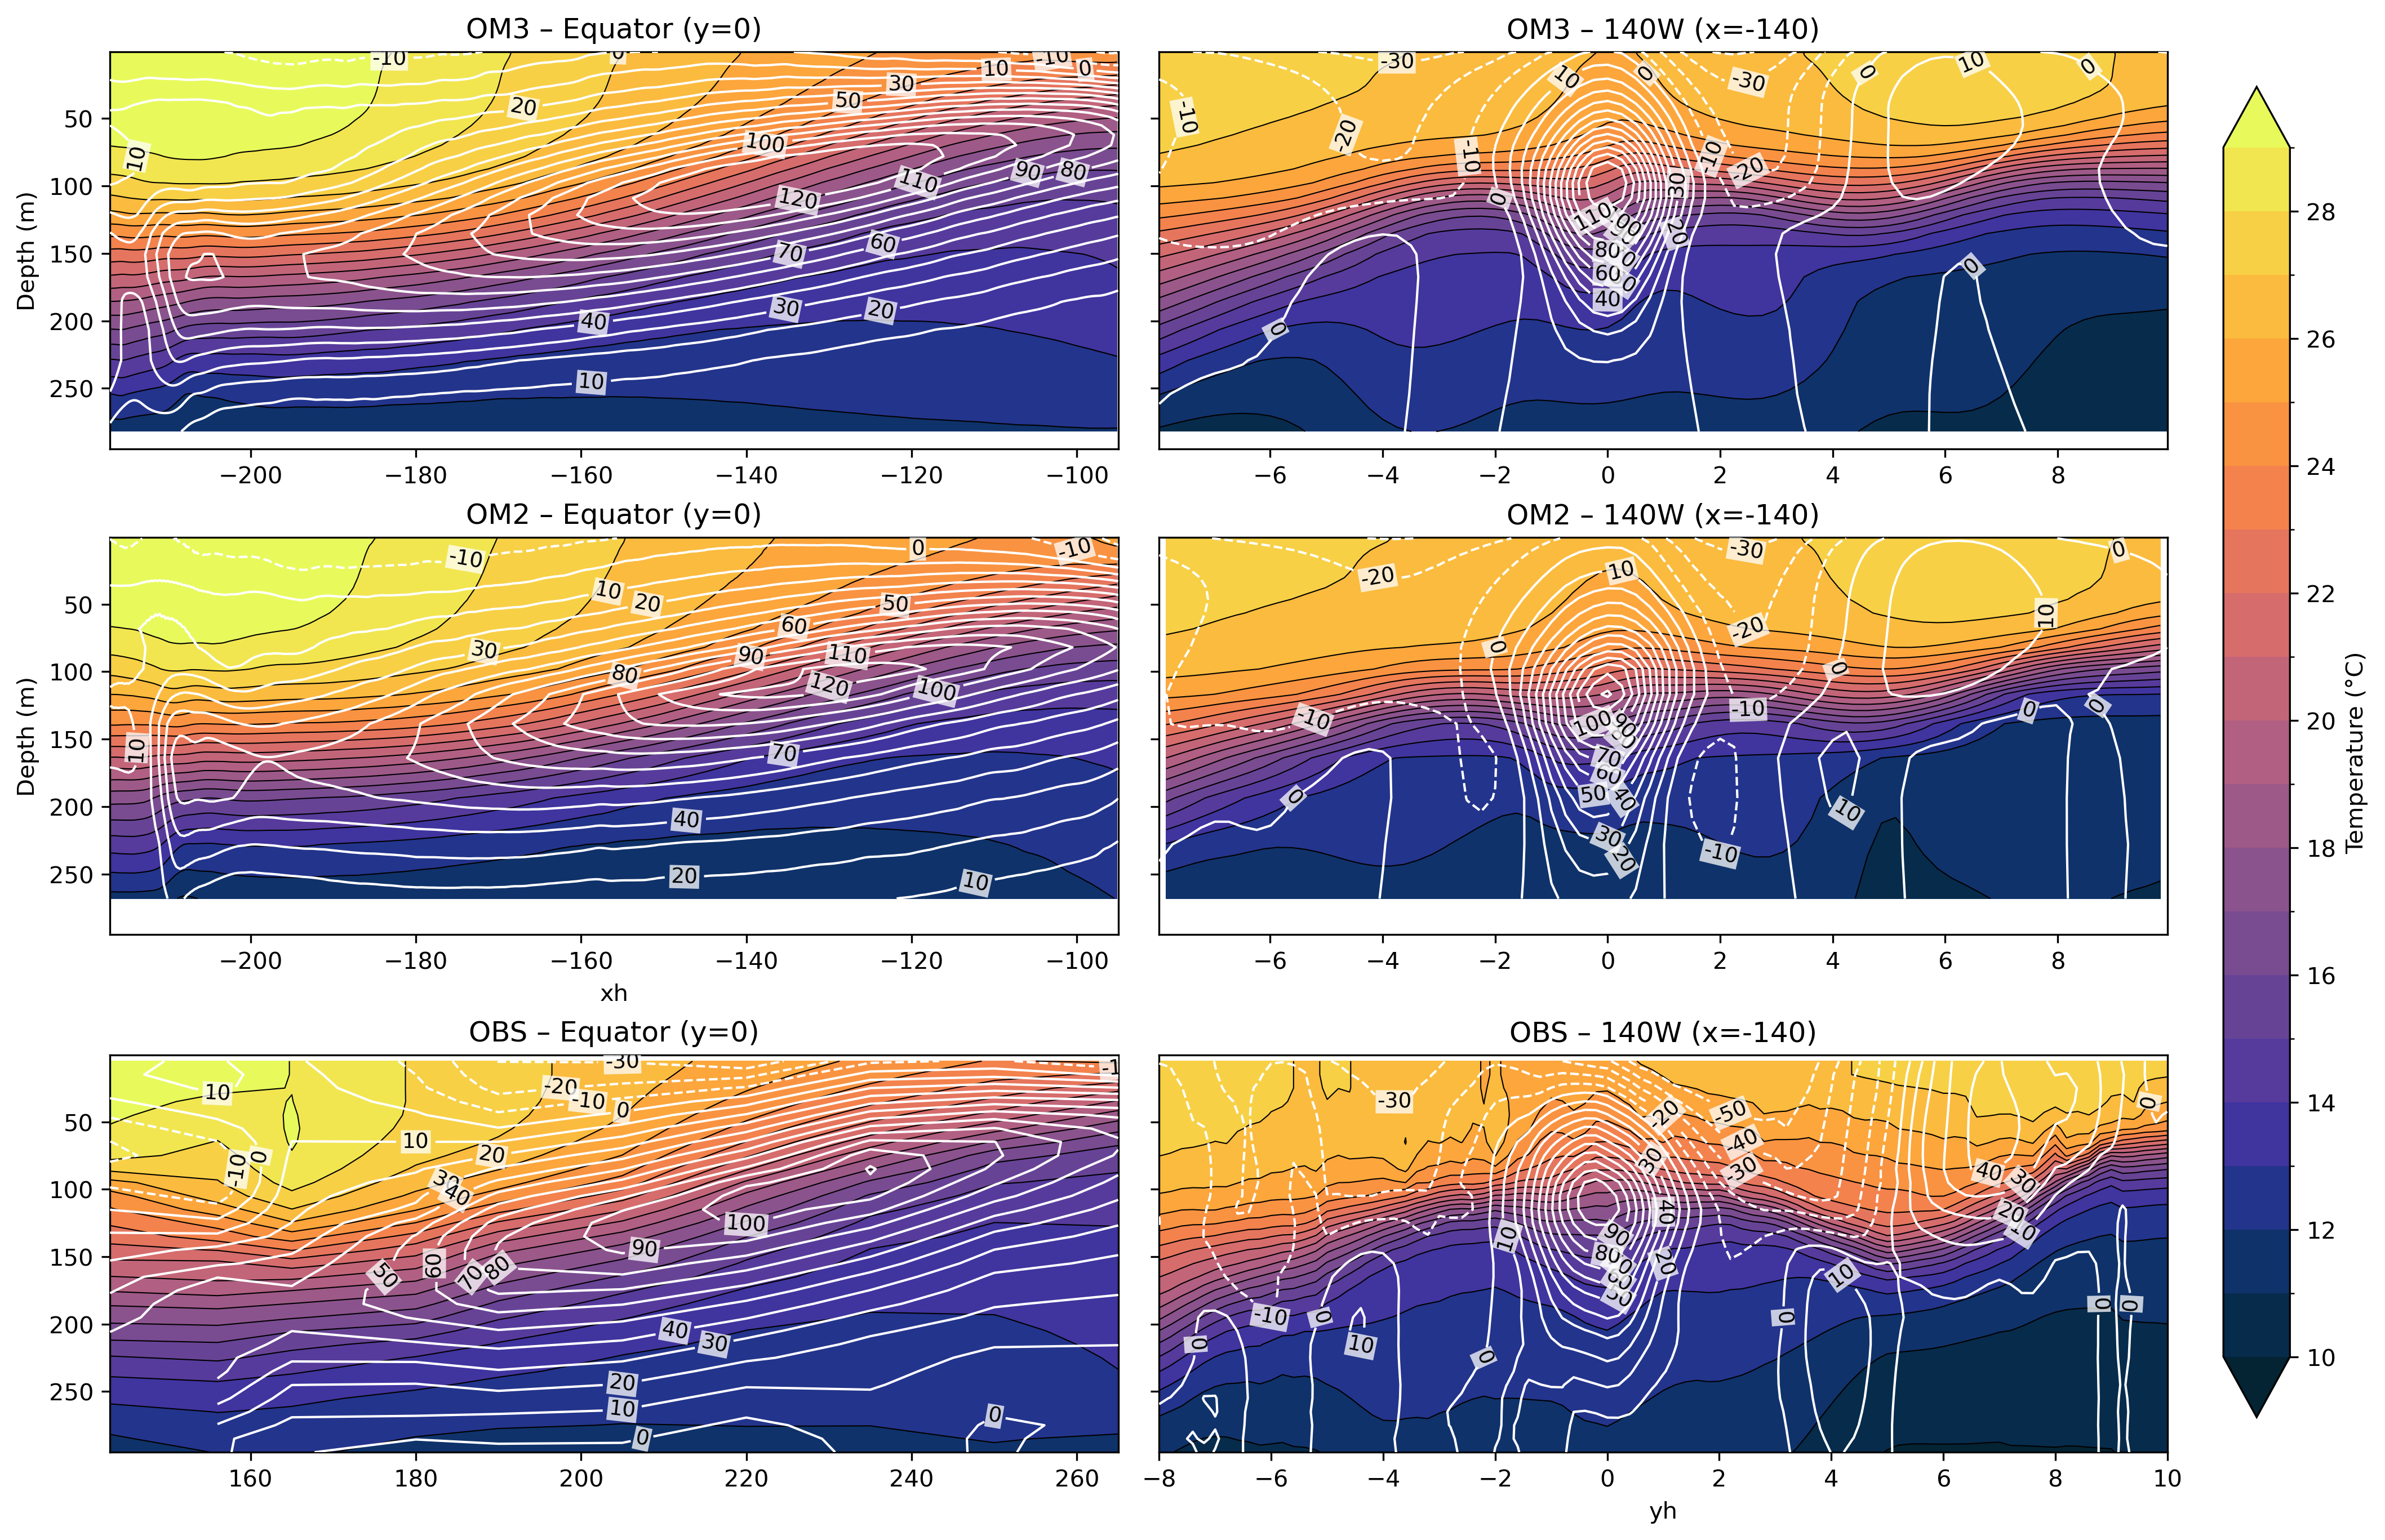

In [ ]:
clevels_temp = np.arange(10., 30., 1.)
clevels_u = np.arange(-50, 130, 10)

fig, axs = plt.subplots(
    3, 2,
    figsize=(14, 9),
    sharey=True,
    constrained_layout=True
)

# OM3 row
cf00, ct00, _ = plot_pair(
    axs[0, 0],
    temp_eq_om3, u_eq_om3,
    xdim_temp="xh", xdim_u="xq",
    clevels_temp=clevels_temp,
    clevels_u=clevels_u,
    title="OM3 – Equator (y=0)",
    show_ylabel=True
)
plot_pair(
    axs[0, 1],
    temp_140w_om3, u_140w_om3,
    xdim_temp="yh", xdim_u="yh",
    clevels_temp=clevels_temp,
    clevels_u=clevels_u,
    title="OM3 – 140W (x=-140)"
)

# OM2 row
plot_pair(
    axs[1, 0],
    temp_eq_om2, u_eq_om2,
    xdim_temp="xh", xdim_u="xq",
    clevels_temp=clevels_temp,
    clevels_u=clevels_u,
    title="OM2 – Equator (y=0)",
    show_ylabel=True,
    # show_xlabel=True
)
plot_pair(
    axs[1, 1],
    temp_140w_om2, u_140w_om2,
    clevels_temp=clevels_temp,
    clevels_u=clevels_u,
    xdim_temp="yh", xdim_u="yh",
    title="OM2 – 140W (x=-140)",
)

# obs row
plot_pair(
    axs[2, 0],
    temp_eq_obs, u_eq_obs,
    xdim_temp="xh", xdim_u="xq",
    clevels_temp=clevels_temp,
    clevels_u=clevels_u,
    title="OBS – Equator (y=0)",
    show_ylabel=True,
    show_xlabel=True
)
plot_pair(
    axs[2, 1],
    temp_140w_obs, u_140w_obs,
    clevels_temp=clevels_temp,
    clevels_u=clevels_u,
    xdim_temp="yh", xdim_u="yh",
    title="OBS – 140W (x=-140)",
    show_xlabel=True
)

cbar = fig.colorbar(cf00, ax=axs, orientation="vertical", shrink=0.95, pad=0.02)
cbar.set_label("Temperature (°C)")

plt.show()
plt.savefig(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')


In [ ]:

mkmd("Temperature and Zonal velocity transects","`"+notebook_name+"`: Contours (depth-longitude @ equator, depth-latitude @ 220E) of temperature and zonal velocity. Compared to observational estimate from Johnson et al. (2002).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
client.close()

2026-01-15 21:10:29,853 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2026-01-15 21:10:29,854 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2026-01-15 21:10:29,855 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2026-01-15 21:10:29,856 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2026-01-15 21:10:29,867 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2026-01-15 21:10:29,868 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2026-01-15 21:10:29,901 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
